In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit, minimize
from scipy.stats import kruskal, anderson, kstest, chisquare, power_divergence, expon
#from scikit_posthocs import posthoc_dunn, sign_plot, sign_array
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import csv

plt.rcParams['figure.figsize'] = (9,4)
plt.rcParams['figure.facecolor'] = 'w'

# Load data.

### Load mitochondria and synapse data

In [2]:
interslice_distance = 240e-3    ##  240 nm == 0.240 µm
# synapse_codes = {1:'Presynapse', 2:'Postsynapse', 3:'Cell Body'}
synapse_codes = {'Presynapse':1, 'Postsynapse':2, 'Both':3, 'Cell Body':4}
data     = pd.read_excel('data/cleaned.xlsx', sheet_name=None, index_col='image #')
for k,df in data.items():
    data[k][pd.isna(data[k])] = 0
    data[k].rename(columns=lambda c: c.split(' (')[0], inplace=True)
display(data['1-1'].iloc[:3])

# List of neurons in the dataset.
neurons = list(set([k.split('-')[0] for k in data.keys()]))
# List of branches belonging to each neuron.
branch_dict = { neuron:[k for k in data.keys() if k.split('-')[0]==neuron] for neuron in neurons }
# display(branches)

total area  mito area 1  mito area 2  mito area 3  synapse
image #                                                            
1          0.263897     0.046385          0.0          0.0        0
2          0.283627     0.047020          0.0          0.0        0
3          0.366879     0.051441          0.0          0.0        2

In [3]:
synapse_data = pd.read_excel('data/Synapse Start and End.xlsx', sheet_name=None, header=(1,2))
synapse_data = { k.split(' ')[-1].split('_')[0]:df for k,df in synapse_data.items() }
synapses = { 'Postsynapse':{}, 'Presynapse':{} }

def extract_ranges(df):
    # Sometimes slice numbers have an "a" or "b" at the end. Discard them
    # by force-converting them to integers and then dropping NaNs.
    df = df.apply(pd.to_numeric, errors='coerce').dropna().astype(int).values
    df[:,1] += 1 # End slice is one past the last known slice to behave like a range.
    return df.tolist()

for k,df in synapse_data.items():
    for synType in ['Presynapse','Postsynapse']:
        synapses[synType][k] = extract_ranges(df[synType][['Image Slice Start','Image Slice End']])

### Load neuron info

In [4]:
neuron_info = pd.read_excel('data/Neuron List.xlsx', index_col='ID', keep_default_na=False)
neuron_info = neuron_info[neuron_info.filter(regex='^(?!Unnamed)').columns]
neuron_info.index = neuron_info.index.map(str)
display(neuron_info.iloc[:3])

# # Make sure `cleaned.xlsx` and `Neuron List.xlsx` have the same neurons.
# N1 = set(neurons)
# N2 = set(neuron_info.index)
# print(N1==N2)
# print(N1-N2, N2-N1)

## 20 neurons

Name     Side                               Full Name          Type  \
ID                                                                        
113  DD3  ventral  Dorsal D-type Motor Neuron 3 (ventral)  motor neuron   
43   DD3   dorsal   Dorsal D-type Motor Neuron 3 (dorsal)  motor neuron   
123  AS5  ventral   A-type Short Motor Neuron 5 (ventral)  motor neuron   

    Neurotransmitter Axon/Dendrite  
ID                                  
113             GABA      dendrite  
43              GABA          axon  
123             GABA

In [5]:
# Get list of neurons matching a condition.
# For each argument, provide a value or list/tuple of values.
def get_neurons(Name=None, Type=None, Neurotransmitter=None, Side=None, neuron_info=neuron_info):
    I = pd.Series(data=True, index=neuron_info.index)
    for c in ['Name','Type','Neurotransmitter','Side']:
        v = eval(c)
        if isinstance(v, (list,tuple)):
            I_ = pd.Series(data=False, index=neuron_info.index)
            for v_ in v:
                I_ = I_ | (neuron_info[c]==v_)
            I  = I & I_
        elif not v is None:
            I = I & (neuron_info[c]==v)
    return I[I].index.tolist()
# print(get_neurons(Name=['DD3', 'AVAL']))
# print(get_neurons(Side='dorsal'))

# Alternate filtering tool. More flexible, but requires more typing.
# The condition is a function that takes a dataframe row and return a boolean.
def get_neurons2(func=lambda row:True, neuron_info=neuron_info):
    return [i for i,row in neuron_info.iterrows() if func(row)]
# print(get_neurons2(lambda row: row.Name in ['DD3','AVAL']))
# print(get_neurons2(lambda row: row.Side=='dorsal'))

# Get a list of branches belonging to a list of neurons.
# If branches=='main', only return the main branch of each neuron.
# If branches=='all', return every branch of each neuron.
# If no list of neurons is provided, it's created with get_neurons(**kwargs).
def get_branches(neurons=None, branches='main', **kwargs):
    if neurons is None:
        neurons = get_neurons(**kwargs)
    if branches=='all':
        return [ b for n in neurons for b in branch_dict[n] ]
    if branches=='main':
        return [ n+'-1' for n in neurons ]
# get_branches(get_neurons(Type='interneuron'))
# get_branches(Type='interneuron')

# Prepare analysis. Locate neuron structures.

### Locate synapses and mitochondria

Synapse and mitochondria are stored as lists of range-like pairs of image indices (image where the object appears, image after the last image in which the object appears).

In [6]:
# Given a boolean series where True means an object is present,
# make a list of index ranges, one for each object.
def get_object_ranges(B, discard_edge_objects=False):
    I1 = B & ~B.shift(1, fill_value=False) # Rows where an object starts.
    I1 = I1[I1==True].index # Index of the first row of each object.
    I2 = B & ~B.shift(-1, fill_value=False) # Rows where an object ends.
    I2 = I2[I2==True].index # Index of the last row of each object.
    I  = [ (i1,i2+1) for i1,i2 in zip(I1, I2) ] # Add 1 to get a range-like pair.
    if discard_edge_objects:
        # Shifting with "fill_value=False" above means that an object that is present in the 
        # first image is assumed to start there, and an object that is present in the last image 
        # is assumed to end there. This may skew object length statistics. To avoid that, here we
        # exclude such edge-touching objects from teh results.
        if len(I)>0 and B.iloc[0]==True:
            I.pop(0)
        if len(I)>0 and B.iloc[-1]==True:
            I.pop(-1)
    return I

# Get the list of mitochondria and synapse ranges in every branch over every neuron.
mitochondria = {}
# presynapses  = {}
# postsynapses = {}
for k in data.keys():
    df = data[k]
    mitochondria[k] = sum( [get_object_ranges(df[c]>0) for c in df.columns[1:-1]], [] )
    
#     # !! Temporary: only the first mito column.
#     mitochondria[k] = sum( [get_object_ranges(df[c]>0) for c in df.columns[1:2]], [] )
    
    # By default, ranges are sorted by mito column, then by position within each column.
    # Here I make sure they're sorted entirely by the position of their center.
    if len(mitochondria[k])>0:
        mitochondria[k] = [mitochondria[k][i] for i in np.argsort(np.mean(mitochondria[k], axis=1))]
#     postsynapses[k] = get_object_ranges(df['synapse']==synapse_codes['Post-Synapse'])
#     presynapses[k]  = get_object_ranges(df['synapse']==synapse_codes['Pre-Synapse'])

pre  = [synapse_codes['Presynapse'], synapse_codes['Both']]
post = [synapse_codes['Postsynapse'], synapse_codes['Both']]
presynapses  = { k:get_object_ranges(data[k]['synapse'].isin(pre)) for k in data }
postsynapses = { k:get_object_ranges(data[k]['synapse'].isin(post)) for k in data }

# # Show mitochondrion centroids in branch 1-1 for comparison with Danielle's manually detected centroids.
# print(np.sort(np.mean(mitochondria['1-1'], axis=1)))

mitochondria_by_neuron    = { neuron:sum([ mitochondria[k] for k in branch_dict[neuron] ], []) for neuron in neurons }
# synapses_by_neuron = { neuron:sum([ synapses[k] for k in branches[neuron] ], []) for neuron in neurons }

In [7]:
# Replace auto-extracted synapse data with manual synapse data where available
# (i.e., main branches only).
for n,ranges in synapses['Presynapse'].items():
    presynapses[n+'-1'] = ranges

### Define distance functions

Note that distances should only be computed within a branch. It's possible to compute distances between objects in different branches of the same neuron if the locations of the branching points are known, but it's a bit of a pain and not worth the effort at this time.

In [8]:
#----------------------------------------------------------------
# Types of distances: regular or volumic.

# Distance between two slices, in μm.
def regular_distance(slice1, slice2, signed=False):
    return abs(slice1-slice2)*interslice_distance

# Axonal volume between two slices, in μm^3.
def volumic_distance(slice1, slice2, branch, data=data):
    if slice1>slice2:
        slice1,slice2 = slice2,slice1
    area = data[branch].loc[slice1:slice2,'total area'].values
    return np.trapz(area)*interslice_distance

#----------------------------------------------------------------
# Shortest distance between extended objects.

def distance_segment2segment(segment1, segment2, d):
    segment1 = np.sort(segment1)
    segment2 = np.sort(segment2)
    if segment1[0]>segment2[0]:
        segment1,segment2 = segment2,segment1
    if segment1[1]>=segment2[0]:
        return 0
    return d(segment2[0],segment1[1])

def distance_point2segment(point, segment, d):
    return distance_segment2segment([point,point], segment, d)

#----------------------------------------------------------------
# Distance wrapper calling one of the functions above.

distance_func_dict = {'distance':regular_distance, 'volume':volumic_distance}
def distance(pointOrSegment1, pointOrSegment2, mode, measure='distance', branch=None):
    d = regular_distance
    if measure=='volume':
        d = lambda o1,o2: volumic_distance(o1, o2, branch)
    if mode=='p2c':
        # 1st argument should be a point. 2nd argument should be a segment.
        return d(pointOrSegment1, np.mean(pointOrSegment2))
    if mode=='c2p':
        # 1st argument should be a segment. 2nd argument should be a point.
        return d(np.mean(pointOrSegment1), pointOrSegment2)
    if mode=='p2e':
        # 1st argument should be a point. 2nd argument should be a segment.
        return distance_point2segment(pointOrSegment1, pointOrSegment2, d)
    if mode=='e2p':
        # 1st argument should be a segment. 2nd argument should be a point.
        return distance_point2segment(pointOrSegment2, pointOrSegment1, d)
    if mode=='c2c':
        # Both arguments should be segments.
        return d(np.mean(pointOrSegment1), np.mean(pointOrSegment2))
    if mode=='e2e':
        # Both arguments should be segments.
        return distance_segment2segment(pointOrSegment1, pointOrSegment2, d)
    if mode=='c2e':
        # Both arguments should be segments. The order matters!
        return distance_point2segment(np.mean(pointOrSegment1), pointOrSegment2, d)
    if mode=='e2c':
        # Both arguments should be segments. The order matters!
        return distance_point2segment(np.mean(pointOrSegment2), pointOrSegment1, d)

#----------------------------------------------------------------
# Testing.

# # Test regular distance.
# D = [distance([30,10], [5,0], mode)/interslice_distance for mode in ['c2c','e2e','c2e','e2c']]
# print(', '.join([f'{d:.3g}' for d in D]))
# print('Expected result: 17.5, 5, 15, 7.5.\n')

# D = [distance([30,10], [15,0], mode)/interslice_distance for mode in ['c2c','e2e','c2e','e2c']]
# print(', '.join([f'{d:.3g}' for d in D]))
# print('Expected result: 12.5, 0, 5, 2.5.\n')

# D = [distance([30,10], 5, mode)/interslice_distance for mode in ['c2p','e2p']]
# print(', '.join([f'{d:.3g}' for d in D]))
# print('Expected result: 15, 5.\n')

# D = [distance([30,0], 5, mode)/interslice_distance for mode in ['c2p','e2p']]
# print(', '.join([f'{d:.3g}' for d in D]))
# print('Expected result: 10, 0.\n')

# D = [distance(5, [30,10], mode)/interslice_distance for mode in ['p2c','p2e']]
# print(', '.join([f'{d:.3g}' for d in D]))
# print('Expected result: 15, 5.\n')

# # Test volumic distance.
# print('\nVolumic distance:')
# print(distance([30,10], [5,0], 'e2e', 'volume', '1-1'))
# print(distance([30,10], [5,0], 'c2c', 'volume', '1-1'))

#----------------------------------------------------------------
# Distance to the nearest of a list of objects.

def distance2nearest(object1, listOfObjects2, mode, measure='distance', branch=None):
    return min([distance(object1, object2, mode, measure, branch) for object2 in listOfObjects2])

### Define visualization functions

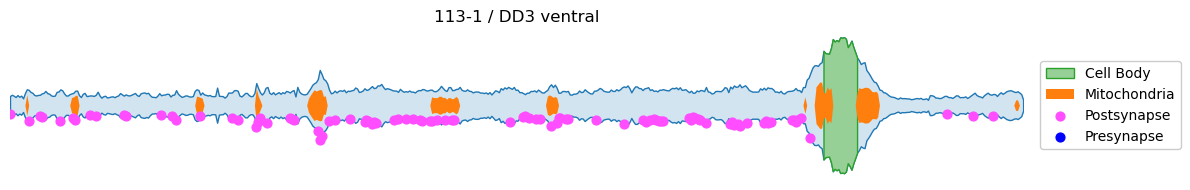

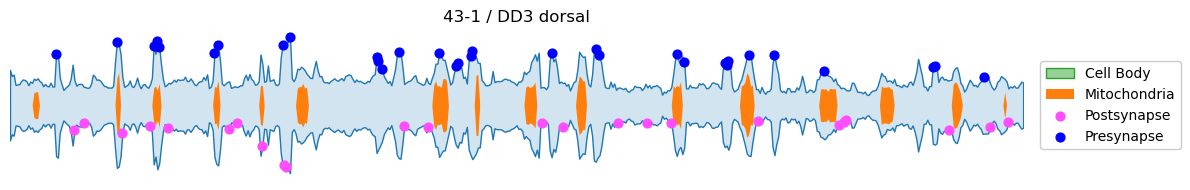

In [9]:
def savefig(fn, tight=True):
    if tight:
        plt.tight_layout()
#     plt.savefig(f'output/{fn}.png', dpi=200)
    plt.savefig(f'output/{fn}.eps')

def alpha2white(color, alpha):
    return alpha*np.array(color) + (1-alpha)

def visualize_branch(branch_id, figsize=(12,2), data=data, 
                     axis_off=True, editable=False):
    df = data[branch_id].copy()
    df = df[df['total area']>0]
    plt.figure(figsize=figsize)
    x = df.index*240e-3 # position along the neuron, in μm

    # Axon.
    y = np.sqrt(df['total area'].values/np.pi)
    c = plt.matplotlib.colors.to_rgb('C0')
    plt.fill_between(x, -y, y, ec=c, fc=alpha2white(c,0.2))

    # Cell body.
    I = df['synapse']==synapse_codes['Cell Body']
    c = plt.matplotlib.colors.to_rgb('C2')
    plt.fill_between(x[I], -y[I], y[I], label='Cell Body', ec=c, fc=alpha2white(c,0.5))
    
    # Mitochondria. Multiple overlapping mitochondria are treated as a 
    # single mitochondrion with the same total cross-sectional area.
    z = df[[c for c in df.columns if 'mito area' in c]].sum(axis=1).values
    z = np.sqrt(z/np.pi)
    c = plt.matplotlib.colors.to_rgb('C1')
    plt.fill_between(x, -z, z, color=c, lw=0, label='Mitochondria')
    
    # Synapses.
    for synType,color,sign in [('Postsynapse',(1,0.3,1),-1),('Presynapse',(0,0,1),1)]:
        code = synapse_codes[synType]
        y_ = sign*np.where(df['synapse']==code,y,np.nan)
        plt.scatter(x, y_, color=color, s=40, zorder=10, label=synType)

    plt.xlim(x[0],x[-1])
    info  = neuron_info.loc[branch_id.split('-')[0]]
    title = f"{branch_id} / {info['Name']} {info['Side']}"
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1.01,0.5), framealpha=1)
    if axis_off:
        plt.axis('off')
    plt.tight_layout()
    if editable:
        # Return the axes object for further editing outside this function.
        return plt.gca()
    else:
        plt.show()

# for k,df in data.items():
for k in ['113-1','43-1']:
    visualize_branch(k, editable=False)
#     savefig(f'branch-profile_{k}')

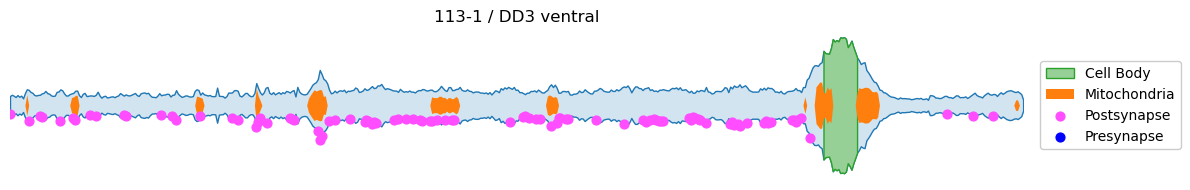

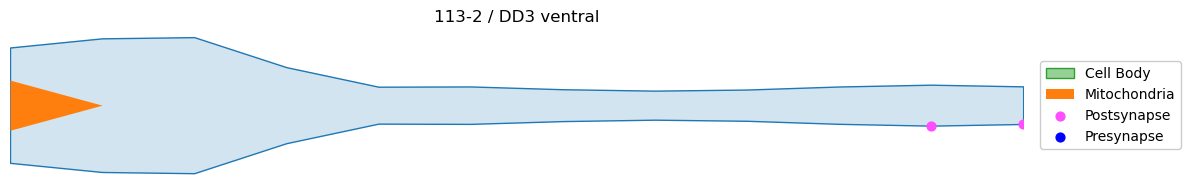

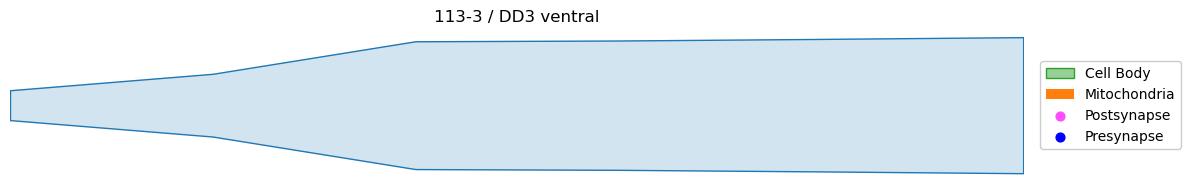

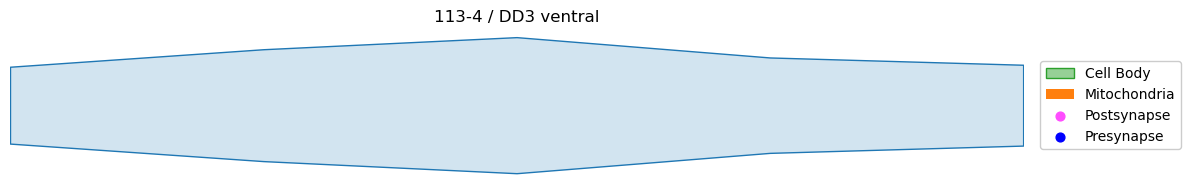

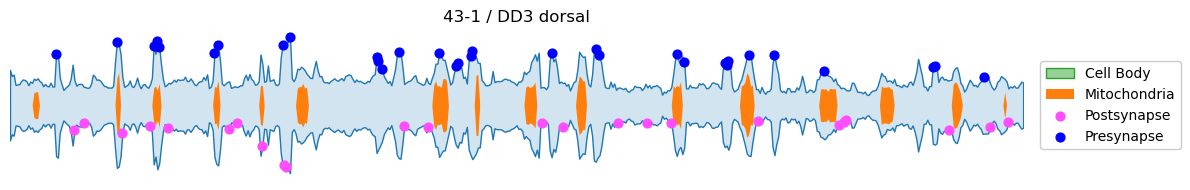

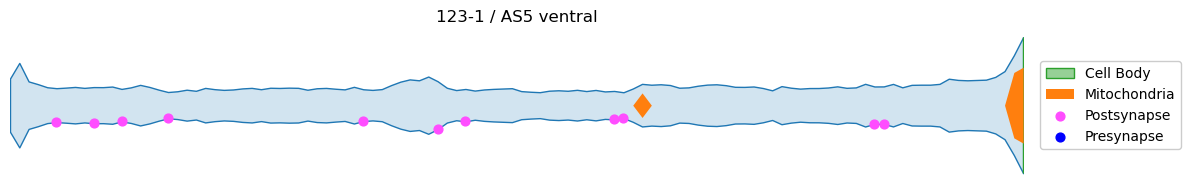

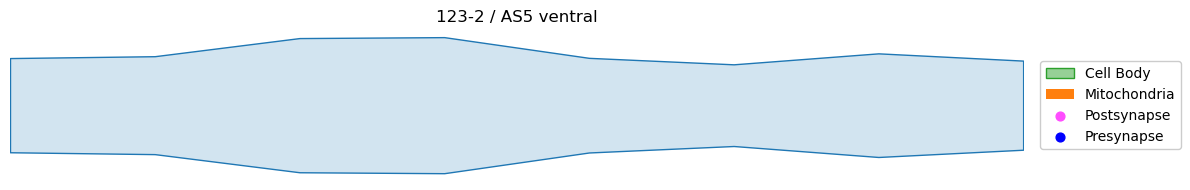

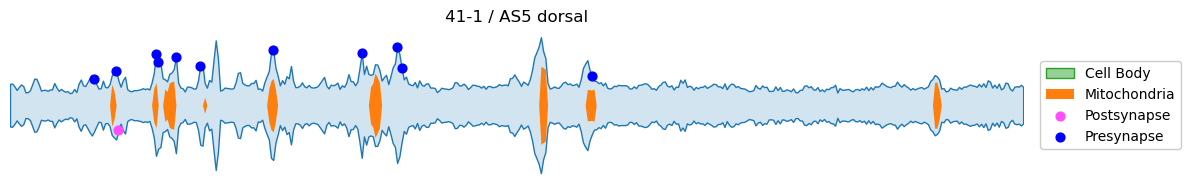

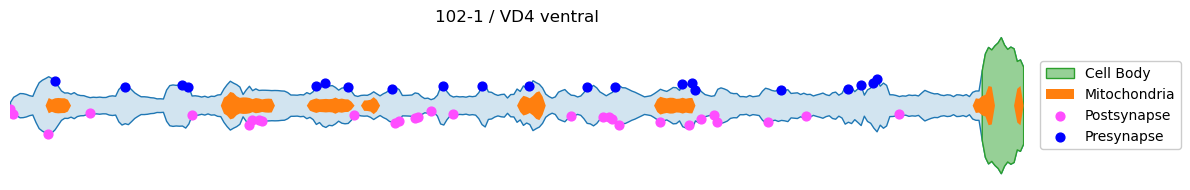

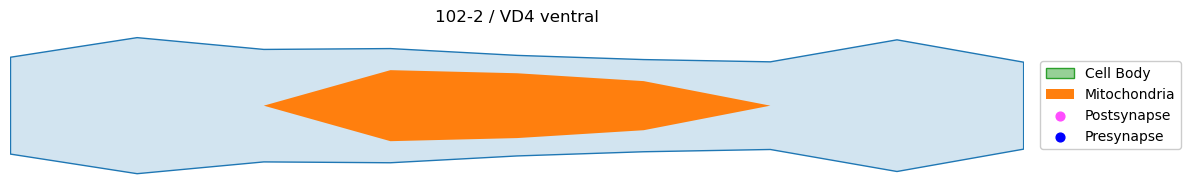

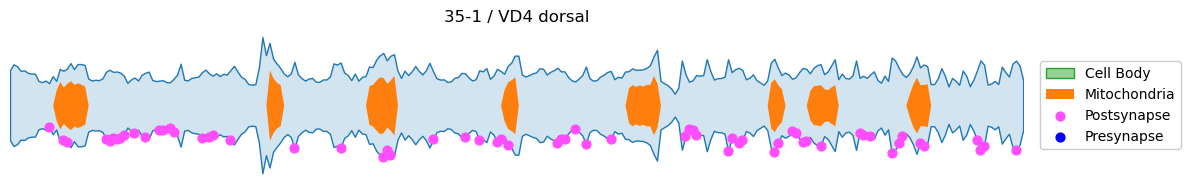

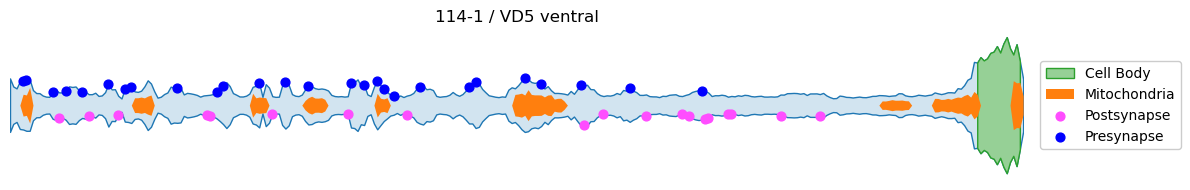

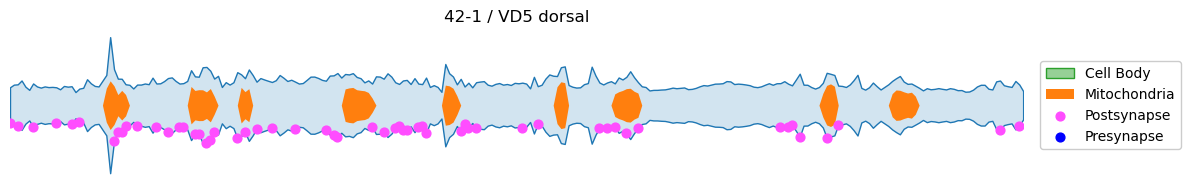

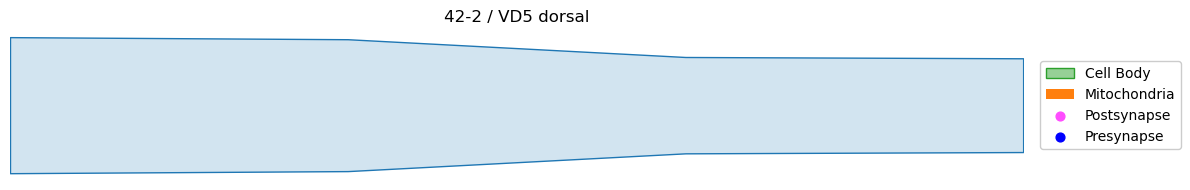

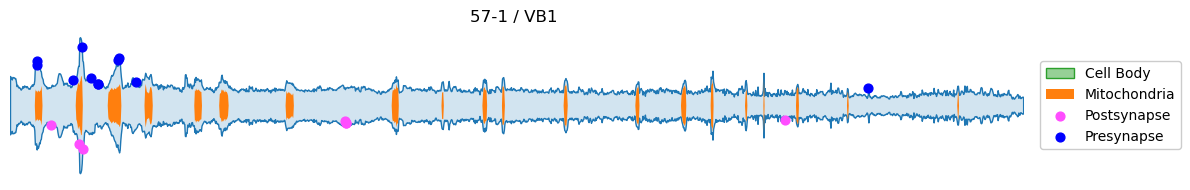

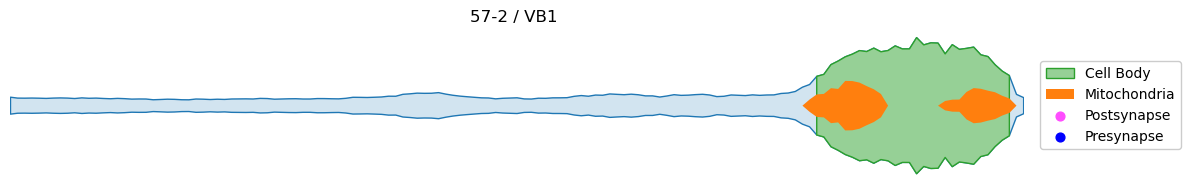

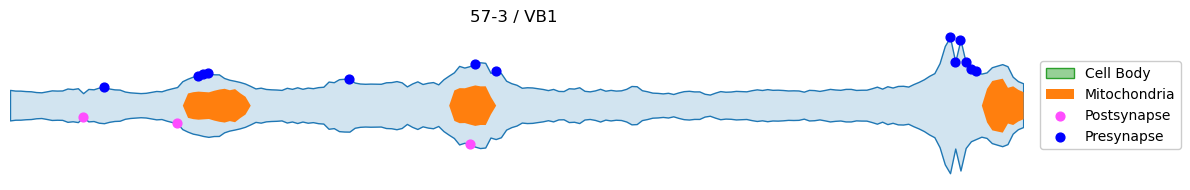

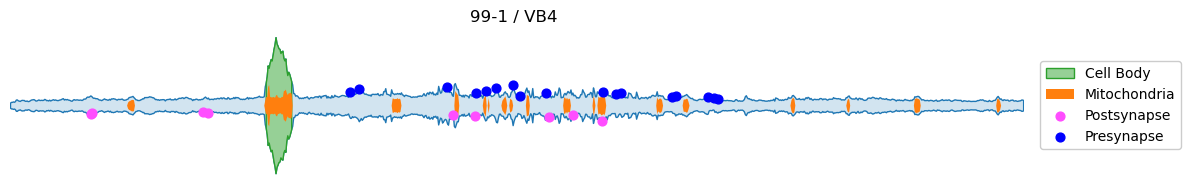

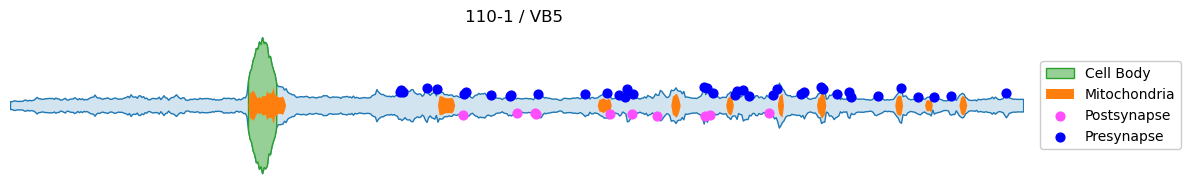

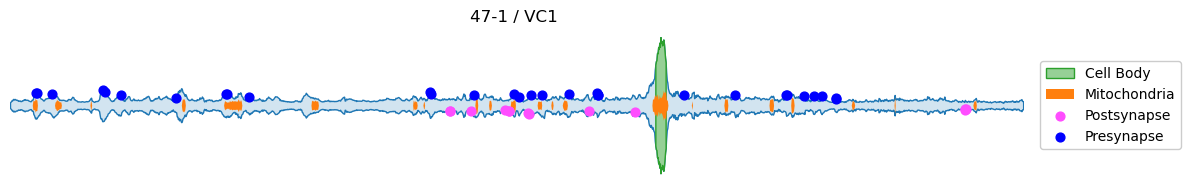

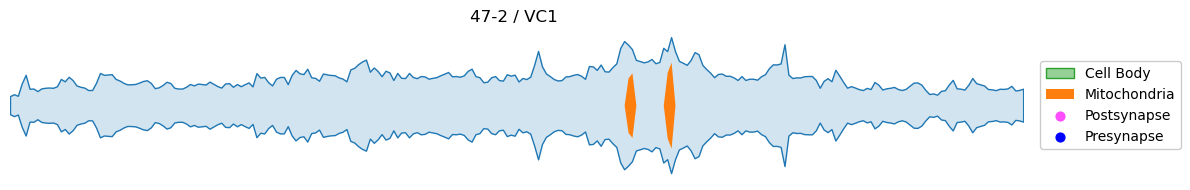

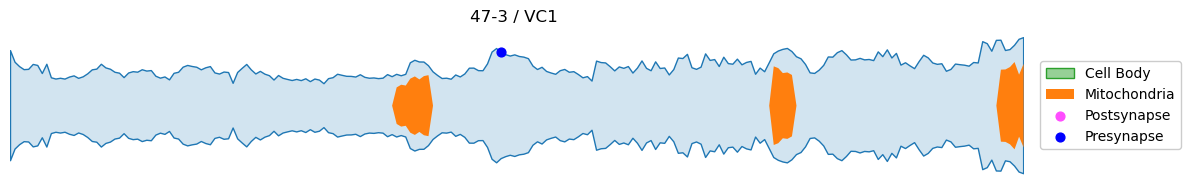

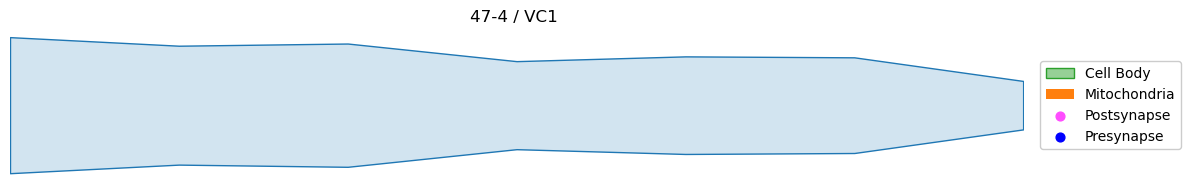

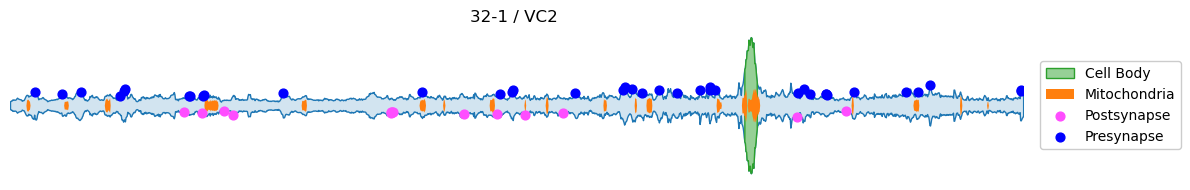

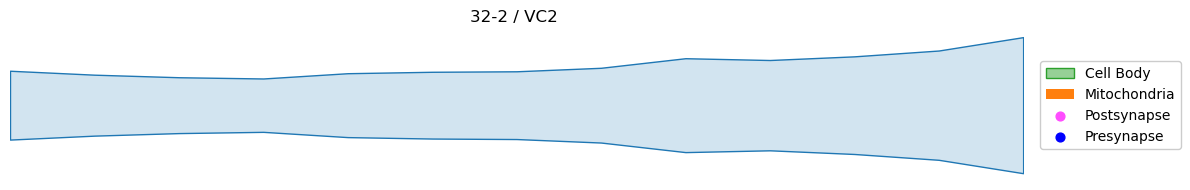

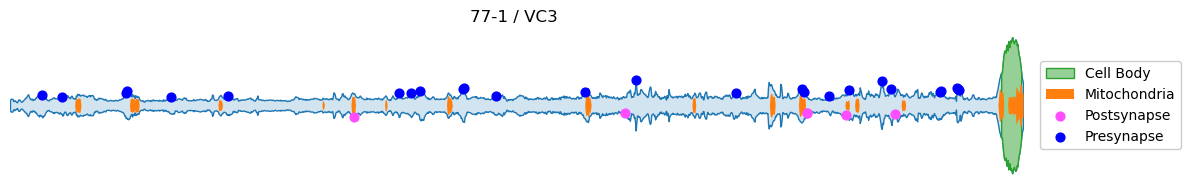

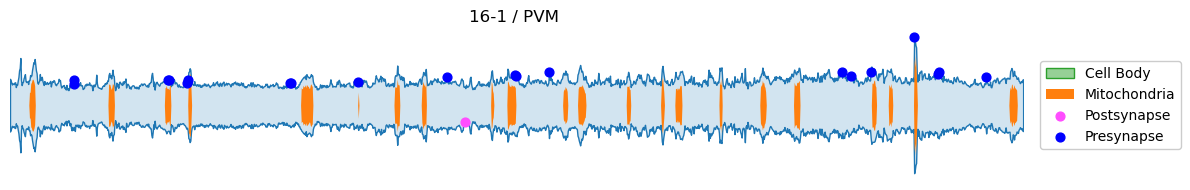

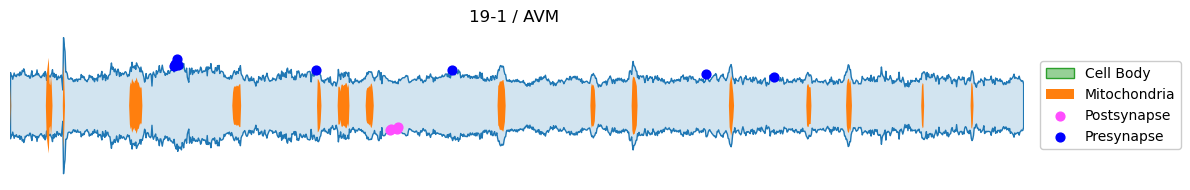

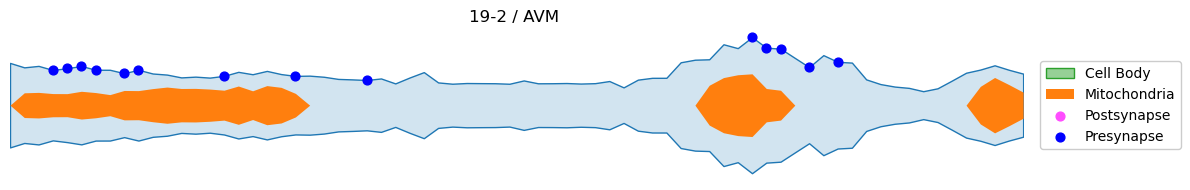

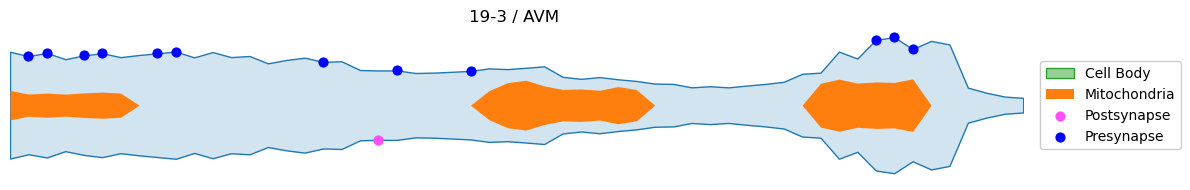

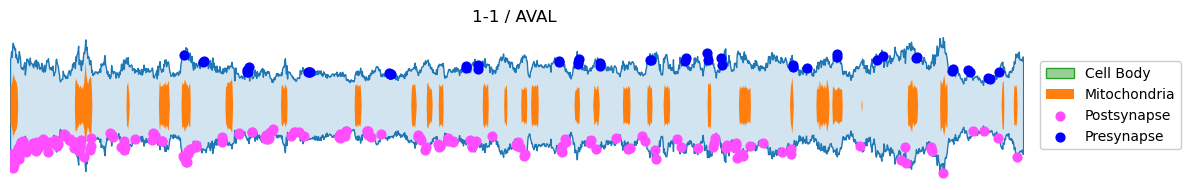

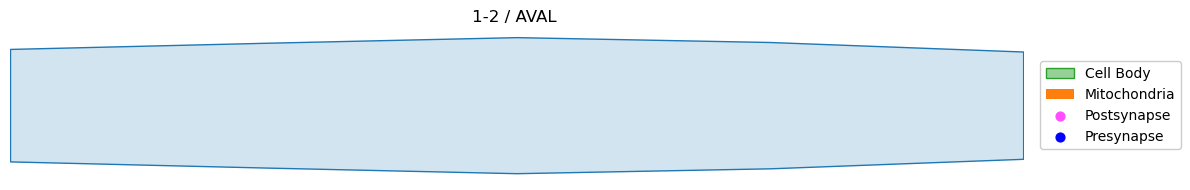

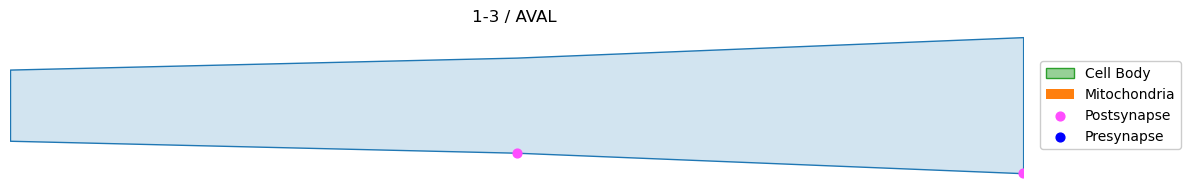

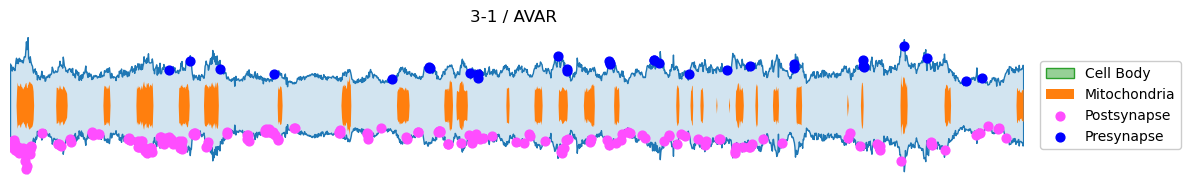

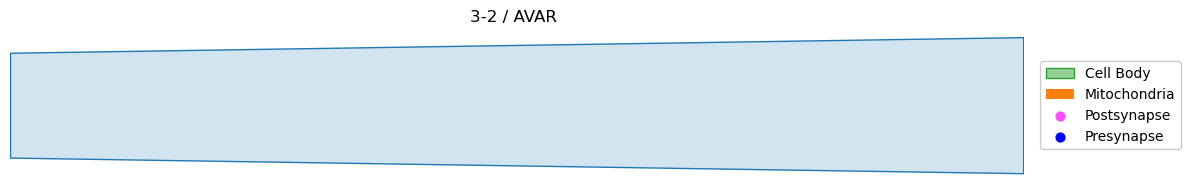

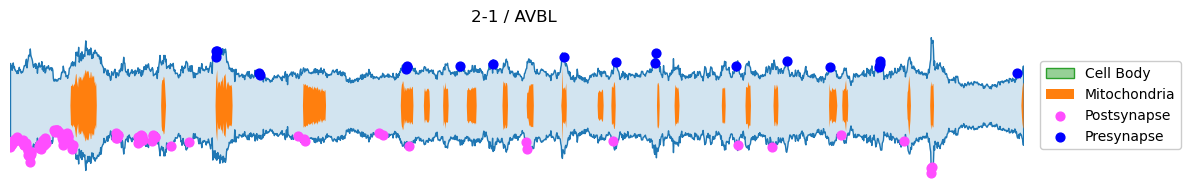

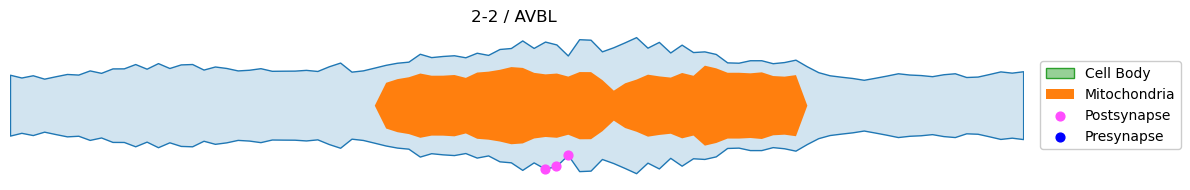

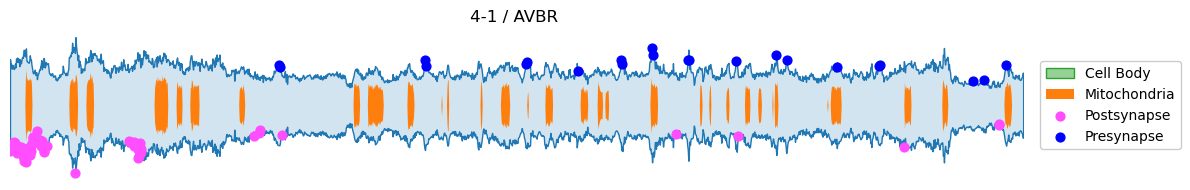

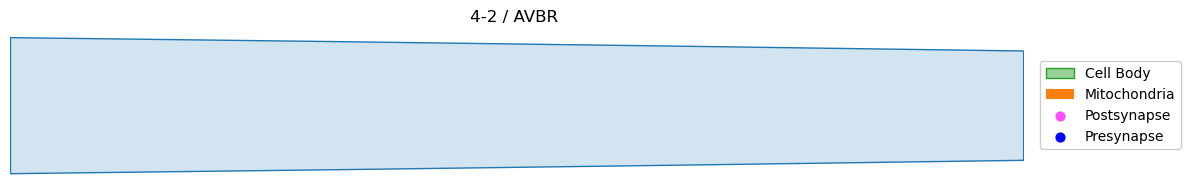

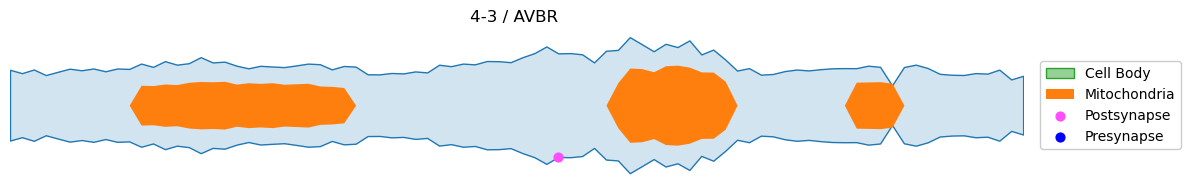

In [38]:
for k in get_branches(branches='all'):
    visualize_branch(k)

#### Looking at cell bodies

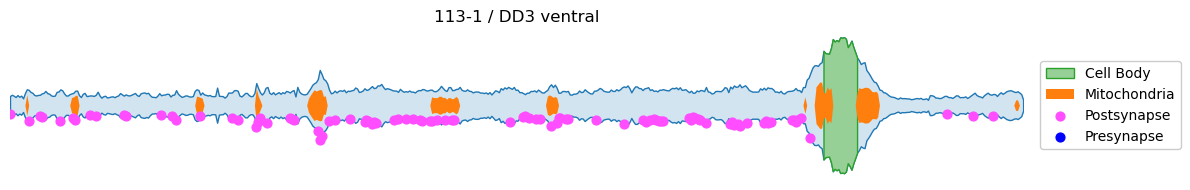

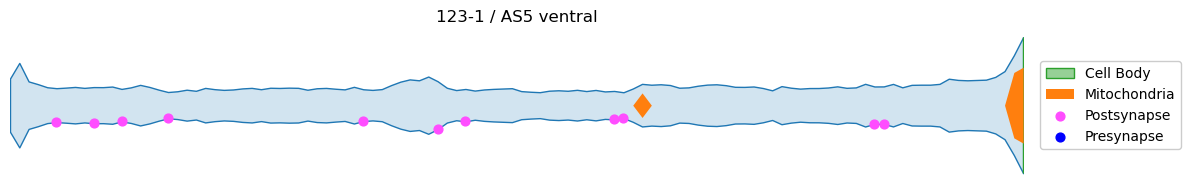

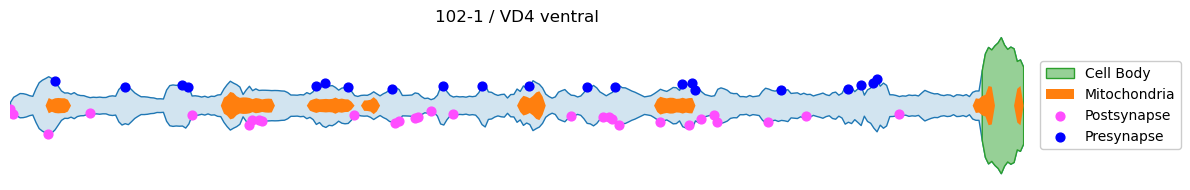

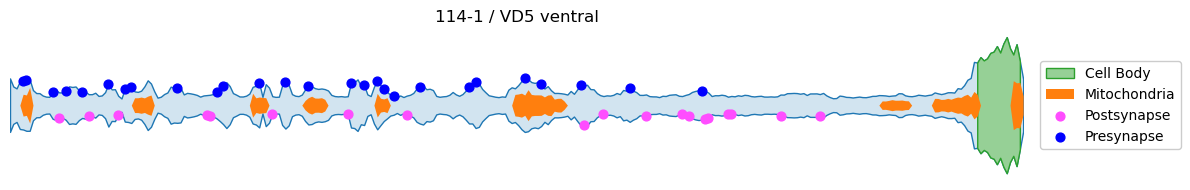

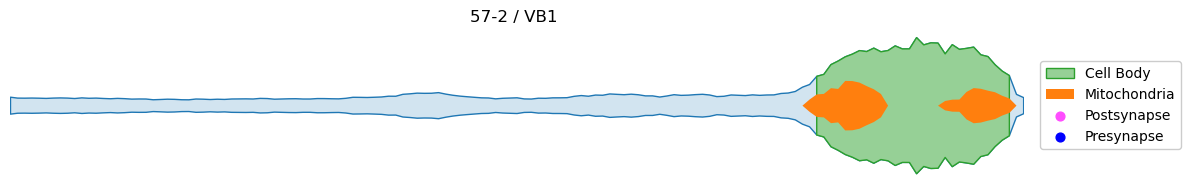

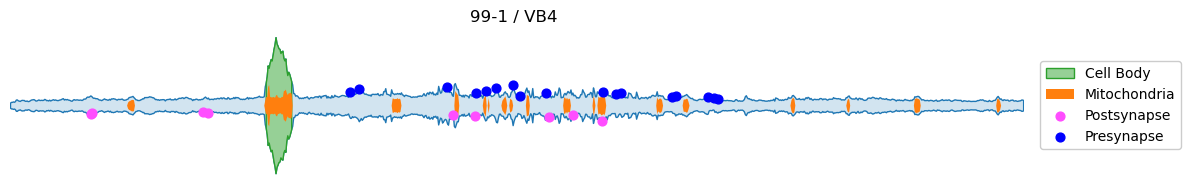

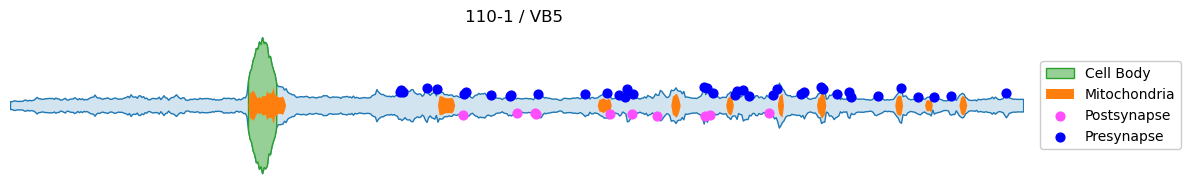

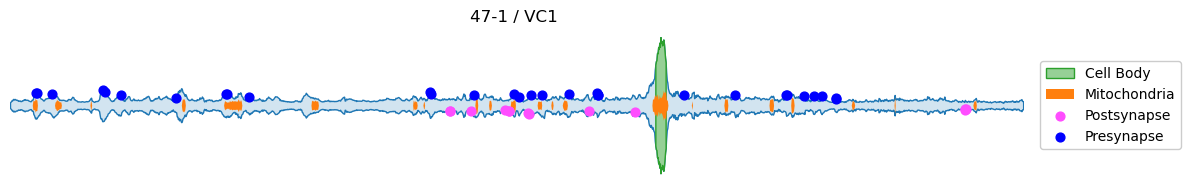

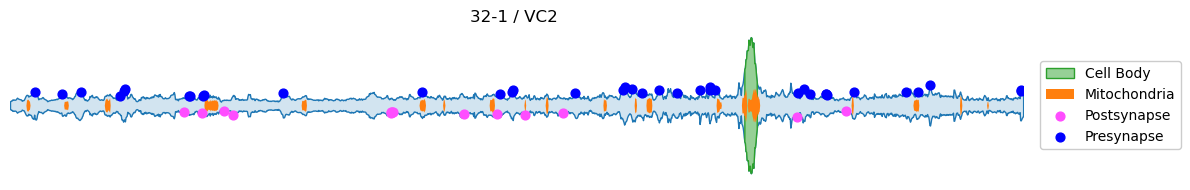

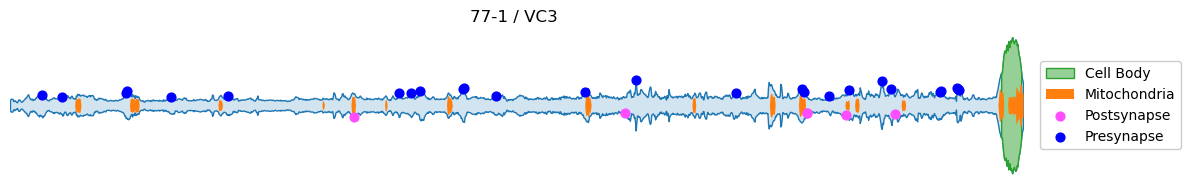

In [10]:
# Visualize every neuron that includes a cell body.
# synapse_codes = {'Presynapse':1, 'Postsynapse':2, 'Both':3, 'Cell Body':4}

%matplotlib inline
for k in get_branches(branches='all'):
    if (data[k]['synapse']==4).any():
        visualize_branch(k)

In [11]:
# # Why can't we see the cell body in 123-1?
# df = data['123-1']
# display(df[df['synapse']==3])
# print(df.index.min(),df.index.max())

# # Answer: only the very last slice is marked as cell body.

In [12]:
get_neurons()

['113',
 '43',
 '123',
 '41',
 '102',
 '35',
 '114',
 '42',
 '57',
 '99',
 '110',
 '47',
 '32',
 '77',
 '16',
 '19',
 '1',
 '3',
 '2',
 '4']

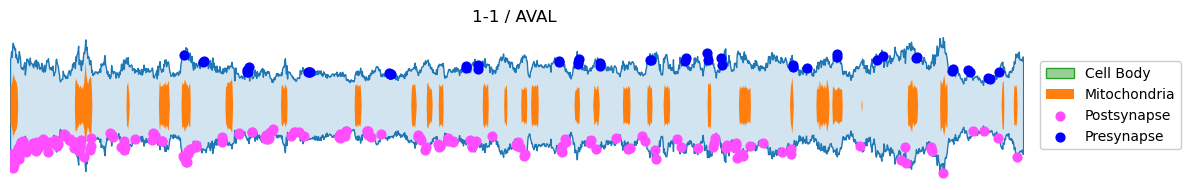

In [13]:
visualize_branch('1-1')

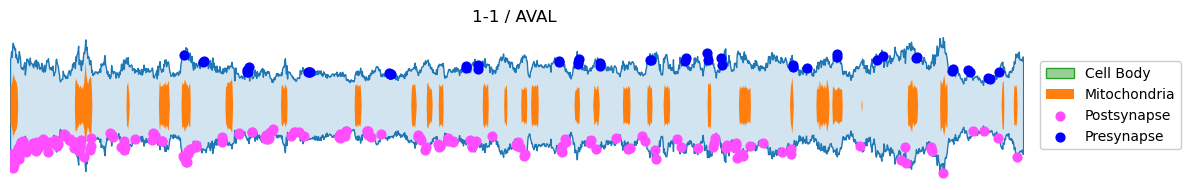

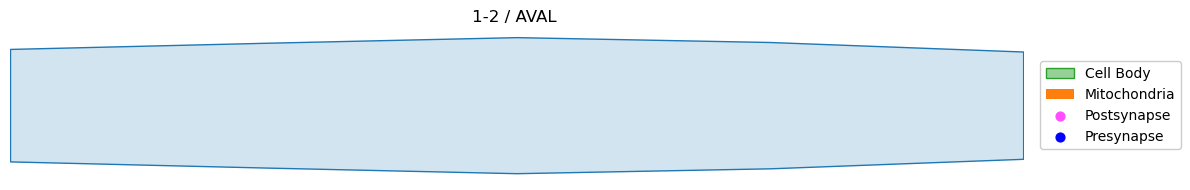

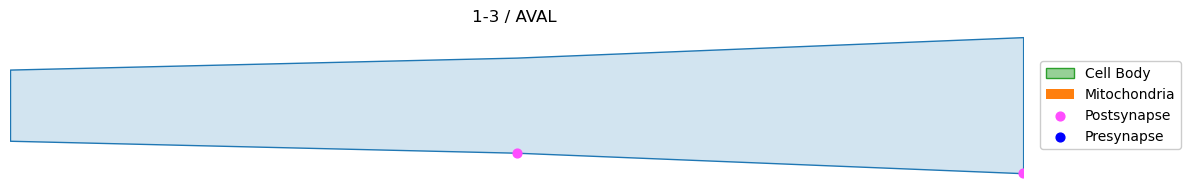

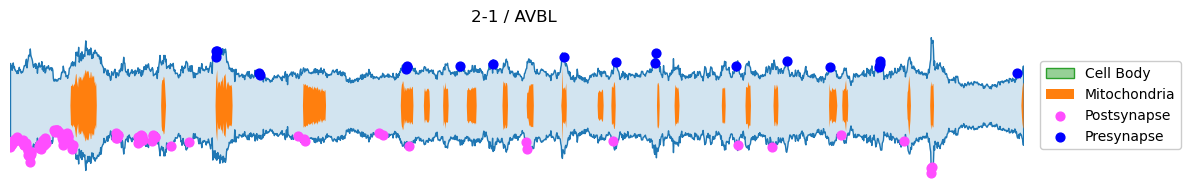

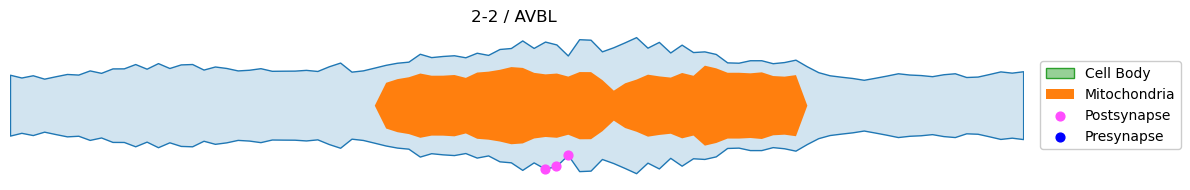

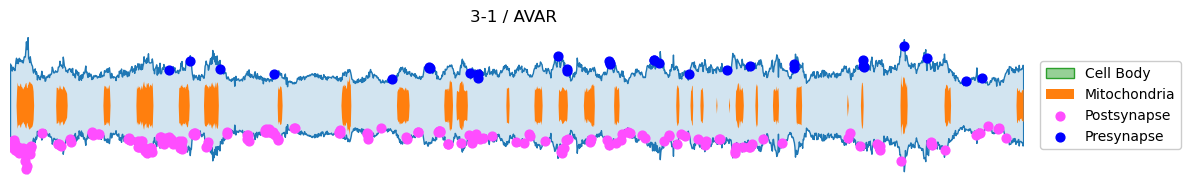

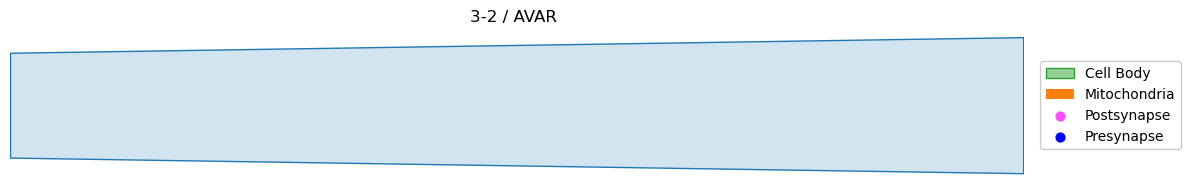

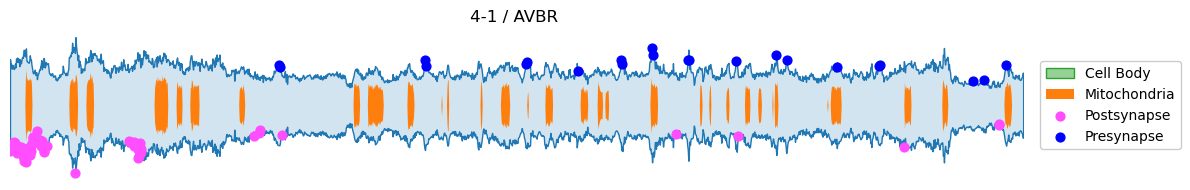

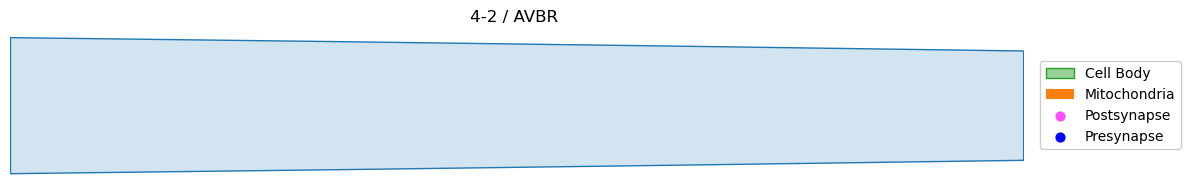

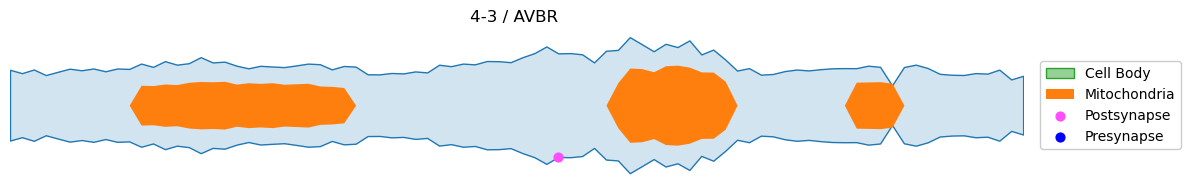

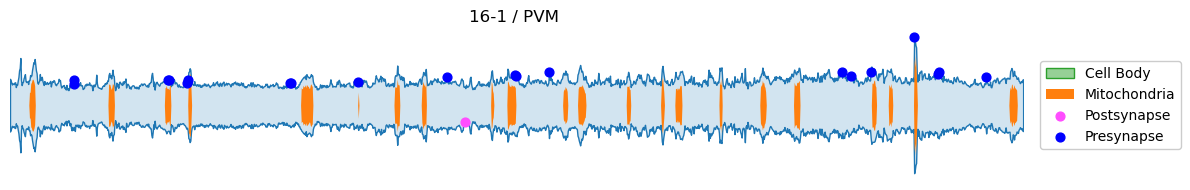

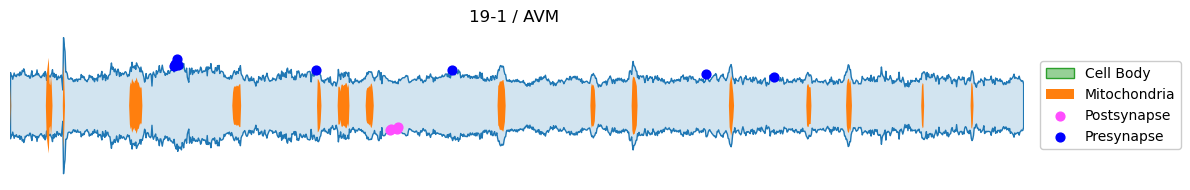

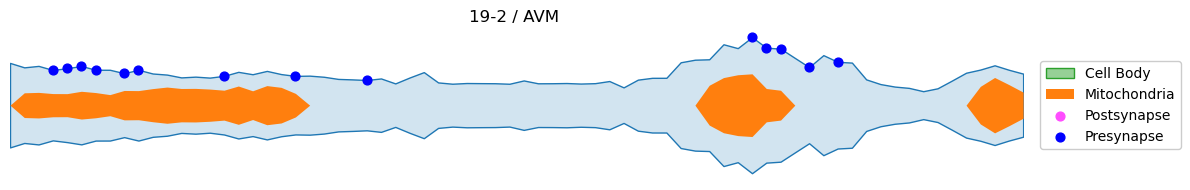

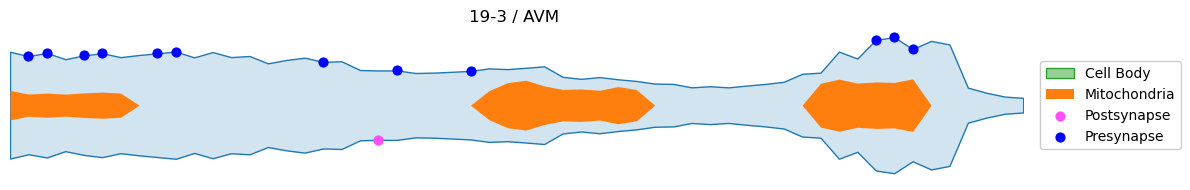

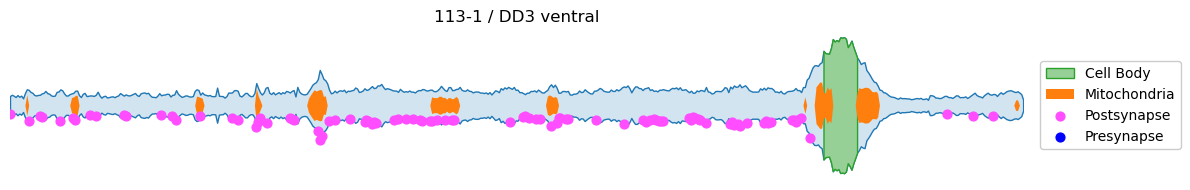

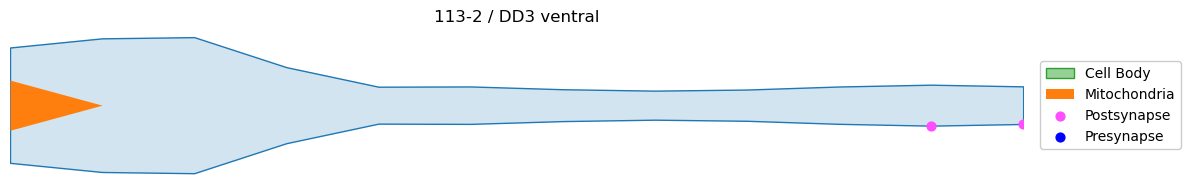

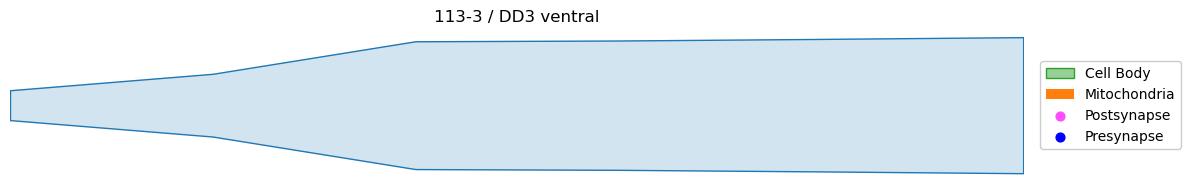

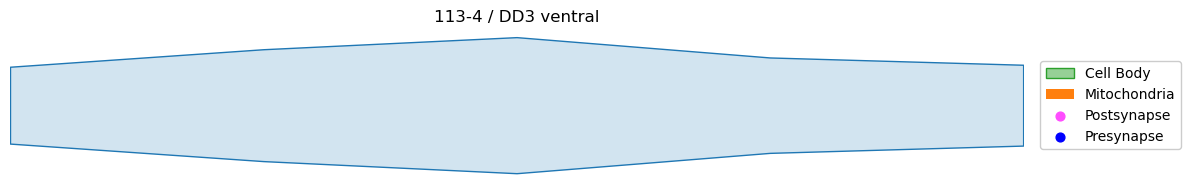

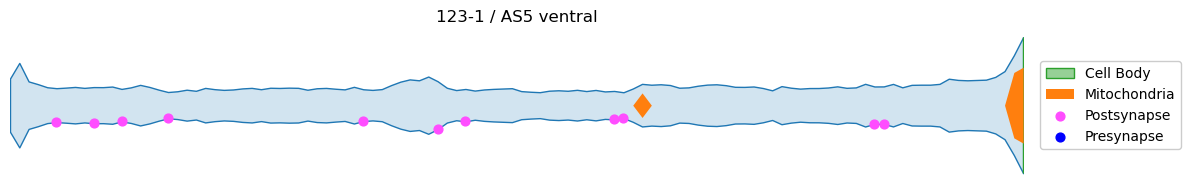

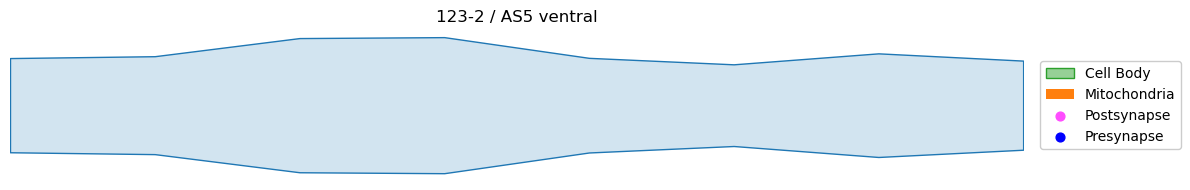

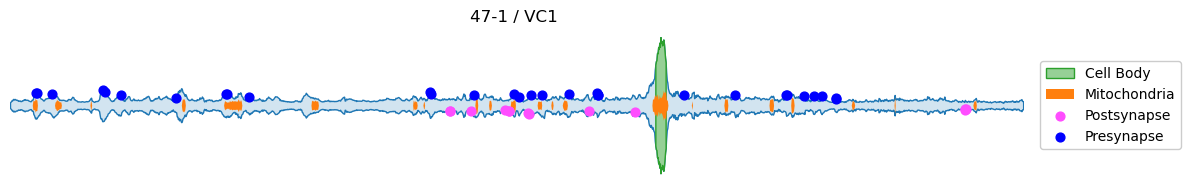

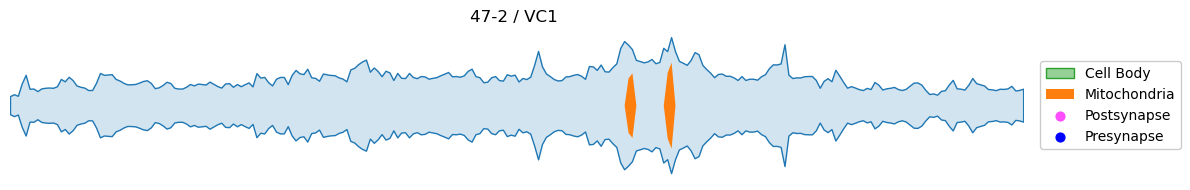

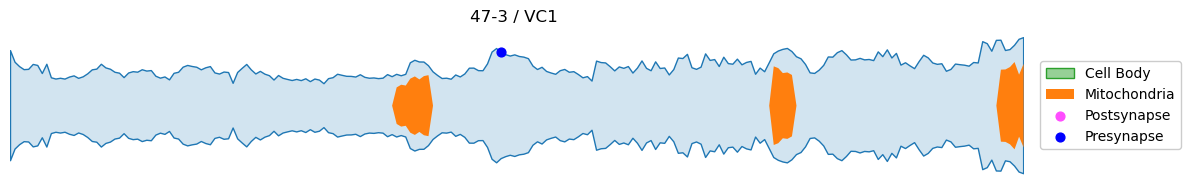

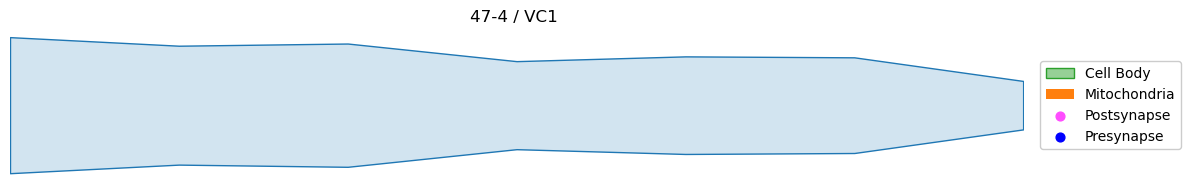

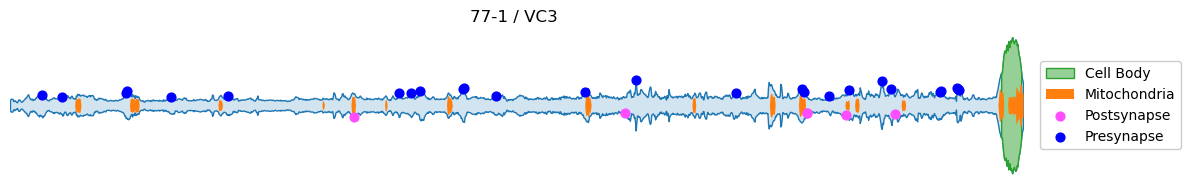

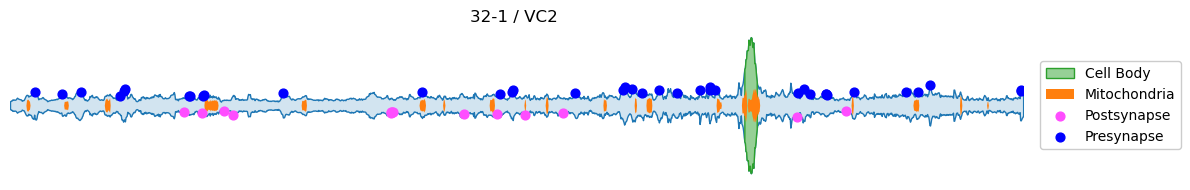

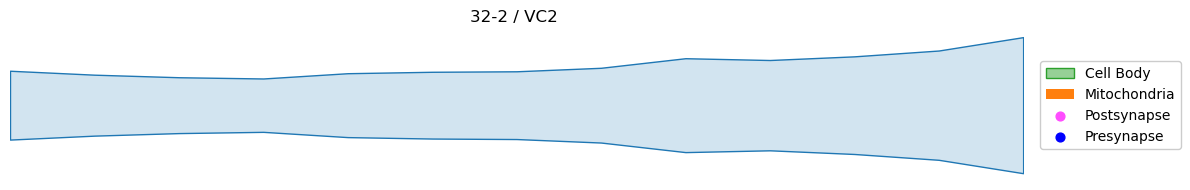

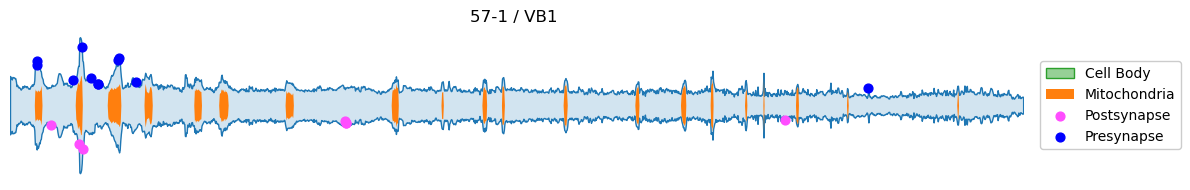

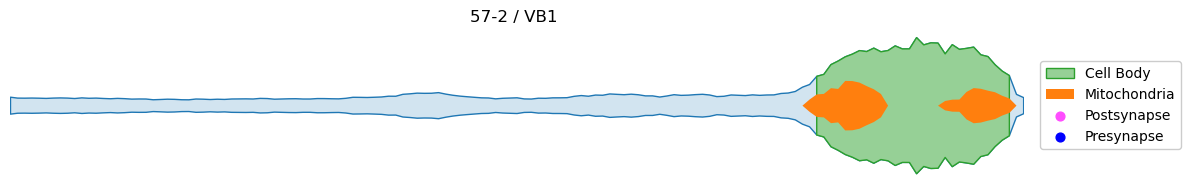

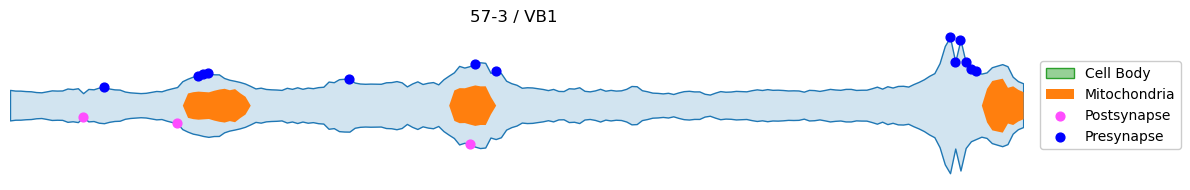

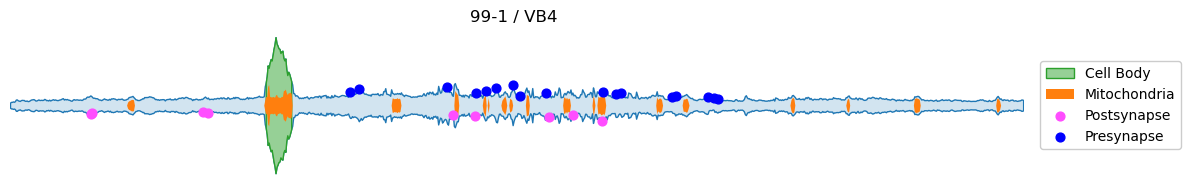

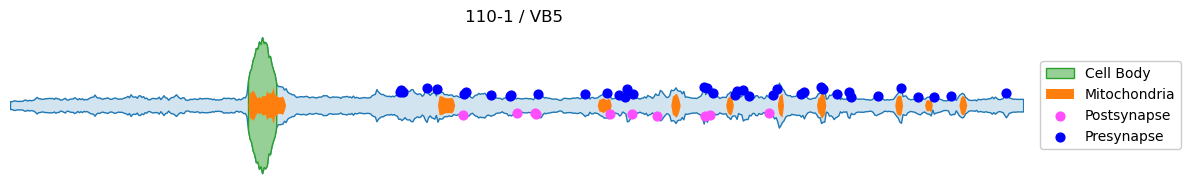

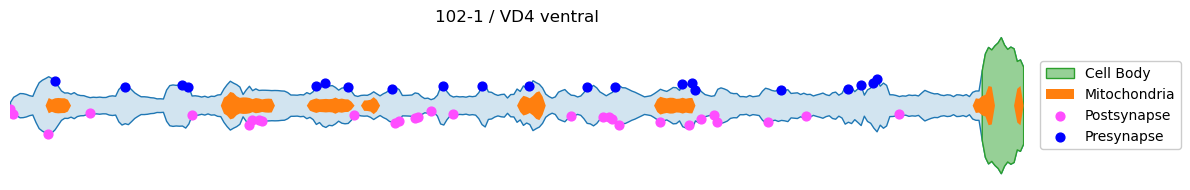

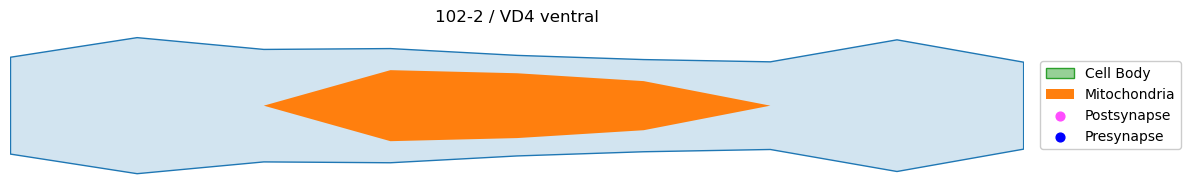

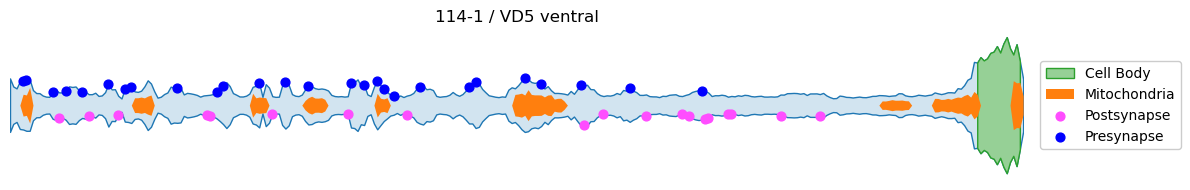

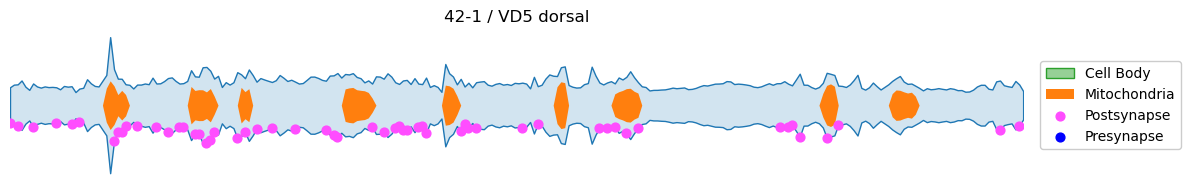

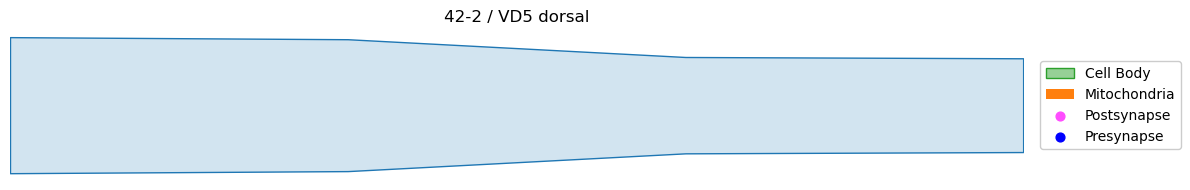

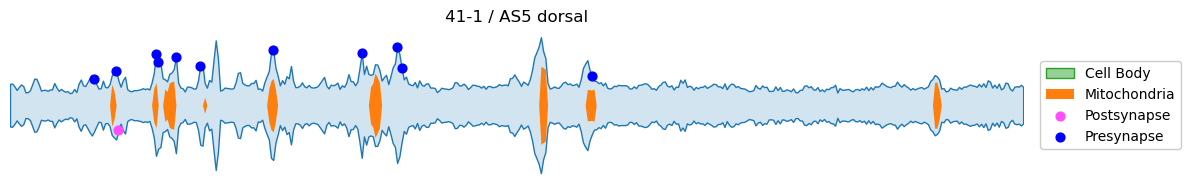

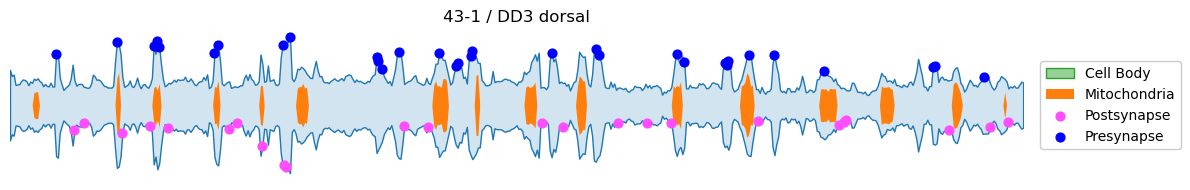

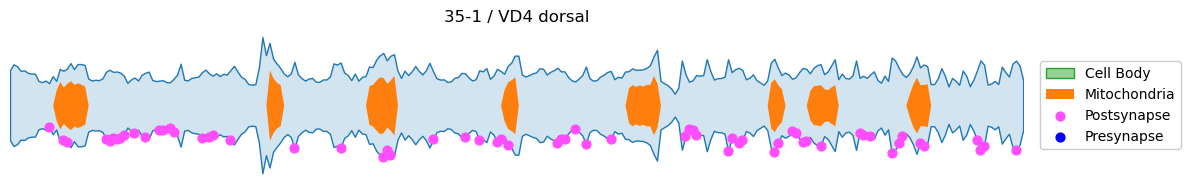

In [14]:
for i in data.keys():
    visualize_branch(i)

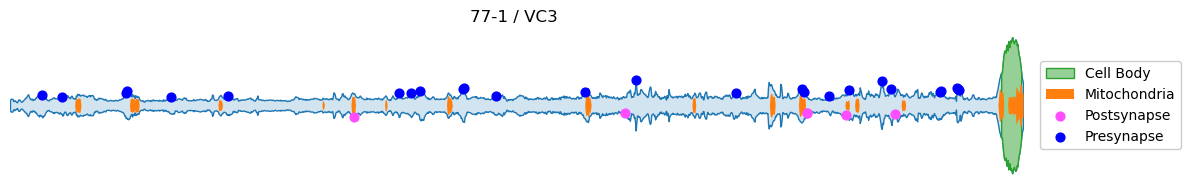

total area  mito area 1  mito area 2  mito area 3  synapse
image #                                                            
275        0.013482     0.000000     0.000000     0.000000        0
276        0.023528     0.000000     0.000000     0.000000        0
277        0.023986     0.000000     0.000000     0.000000        0
278        0.023812     0.000000     0.000000     0.000000        0
279        0.022743     0.000000     0.000000     0.000000        0
...             ...          ...          ...          ...      ...
1840       0.847083     0.137873     0.064947     0.046707        4
1841       0.620581     0.139261     0.063502     0.048828        4
1842       0.436994     0.025184     0.027180     0.050126        0
1843       0.357366     0.015430     0.036641     0.016845        0
1844       0.279775     0.018353     0.037412     0.037810        0

[1570 rows x 5 columns]

In [15]:
visualize_branch('77-1')
data['77-1']

# START HERE to get diffusion geometries

In [16]:
#print(list(data.keys() ))
#print(len( list(data.keys() ) ))
data['1-1']['total area'].min()

0.05194852257766403

# Construct Average consumption rate

Invertebrate ATP estimate will come from our literature squid estimate of 2.16 mM.
    Another candidate value can be constructed by https://wiki.wormbase.org/index.php/Worm_numbers (protein mass)
    along with https://www.nature.com/articles/nature14300/figures/3 figure 3f.
    (330 ng of protein) * 1250 ATP nM per mg  -->

ATP consumption activity is quantified in KJ's analysis.  Base rates are: 

    cyto consum. per volume*s:                             	 33600 ATP molec/µm^3 sec 
    base consum. per s.area*s:                                   1600 ATP molec /µm^2 sec
    avg (1b,1s) signaling consum:                             (5.0663E-19, 4.4848E-20)  ATP moles /µm^2 sec

ATP consumption rates for signalling are dependent on morphology.  The current analysis will only treats surface contributions 
to start.  We'll get an average total area from each bouton, not including the contributions of cell bodies to the total area, and multiply it by the total length, for cyto base consumption.  We'll also use the area for areal consumption.  Recipe:
    
    Assume all shapes are approximately cylindrical
    Surface Area =  2*sqrt(pi * avg of "Total Area") * Length
    Volume       =  avg of "Total Area" * Length

    

In [17]:
header =  ['neuron' , 'length of neuron (µm)' ,'mean carea (µm^2)', 'mean surface area (µm^2)' ,\
           'mean volume (µm^3) no cell body' , 'base consumption mM' , 'signal (areal) Is consumption mM', \
           'signal (areal) Ib consumption mM']
avog   =  6.022e23
base_memdens  = 1600/avog      # moles ATP per µm^3 *sec
base_cytdens  = 33600/avog     # moles ATP per µm^2 *sec
cons_mIbdens , cons_mIsdens  = 5.0663e-19, 4.4848e-20       # surface signalling consumption mole per µm^2 * sec
print( cons_mIbdens/base_memdens,cons_mIsdens/base_memdens )

190.68286625 16.879666


In [36]:
##  Flatten dimensions of each neuron to a long, uniform cylinder
#   Each "Total Area" is a cross sectional area.  However, some values for total area are 0 or blank.
#   Additionally, some have large cell bodies.  To exclude both of these cases, I use bool conditionals to remove
#  0 or blank 'Total area' entries and portions of the cell that have cell bodies when averaging.

geo_consume = []

for k in data.keys():
    df = data[k]
    print(k)
    neuLength = interslice_distance * (len(df[df['total area'] != 0]['total area']) -1)  ## Total Length of Neuron in µm
    if np.any(df['synapse'] == 4):
        cArea           = df.loc[ (df['total area'] > 0)  &  (df['synapse'] != 4)   ] ['total area'].mean()    ## Average Cross Sectional Area
        circumference   = 2* (np.pi * cArea)**0.5               # µm   circumference from avg. cross sectional area
        neuVolume       = neuLength * cArea                     # µm^3 volume from avg. cArea and total neuron length
        sArea           = neuLength * circumference             # µm^2 surface area 
        base_rate_mole  = (sArea*base_memdens + neuVolume * base_cytdens)
        base_rate       =  (base_rate_mole / neuVolume ) * 1e18     #  1e18 changes moles/µm^3 --> moles / m^3  which is mM 
        ib_cons         =  sArea*cons_mIbdens/neuVolume * 1e18 
        is_cons         =  sArea*cons_mIsdens/neuVolume * 1e18
        #print('cb =', round(base_rate, 3), round(ib_cons, 3), round(is_cons, 3))
    else:
        cArea = df[df['total area'] > 0]['total area'].mean()
        circumference   = 2* (np.pi * cArea)**0.5
        neuVolume       = neuLength * cArea
        sArea           = neuLength * circumference
        neuVolume       = neuLength * cArea
        base_rate_mole  = (sArea*base_memdens + neuVolume * base_cytdens)
        base_rate       = (base_rate_mole / neuVolume) *1e18
        ib_cons         =  sArea*cons_mIbdens/neuVolume * 1e18
        is_cons         =  sArea*cons_mIsdens/neuVolume * 1e18
        #print('nocb = ', round(base_rate, 3), round(ib_cons, 3), round(is_cons, 3) )
   #['neuron' , 'mean carea (sq microns)', 'mean surface area (sq microns)' ,\
#           'mean volume (cu microns)' , 'base consumption mM' , 'signal (areal) ib consumption mM','signal (areal) is consumption mM']
    geo_consume += [ [k, neuLength ,cArea, sArea,neuVolume, base_rate, is_cons, ib_cons ]  ] 

1-1
1-2
1-3
2-1
2-2
3-1
3-2
4-1
4-2
4-3
16-1
19-1
19-2
19-3
113-1
113-2
113-3
113-4
123-1
123-2
47-1
47-2
47-3
47-4
77-1
32-1
32-2
57-1
57-2
57-3
99-1
110-1
102-1
102-2
114-1
42-1
42-2
41-1
43-1
35-1


In [19]:
print(header)
#print(np.array(geo_consume))

['neuron', 'length of neuron (µm)', 'mean carea (µm^2)', 'mean surface area (µm^2)', 'mean volume (µm^3) no cell body', 'base consumption mM', 'signal (areal) Is consumption mM', 'signal (areal) Ib consumption mM']


In [20]:
for k in geo_consume:
    print(k)

['1-1', 442.56, 0.1924680113355531, 688.2660852558383, 85.17864309666238, 0.0772640741292449, 0.36238376510089454, 4.093705113116888]
['1-2', 1.2, 0.03176108655668614, 0.7581128425847466, 0.03811330386802337, 0.108644381969982, 0.8920728804297179, 10.077392155995986]
['1-3', 0.72, 0.07526719126699295, 0.7002293067415866, 0.054192377712234924, 0.09012601007480632, 0.5794889479753658, 6.5462559247404455]
['2-1', 442.56, 0.14665219519386588, 600.7881728527583, 64.90239550499729, 0.0803900233567409, 0.4151487439939853, 4.689770071567802]
['2-2', 21.599999999999998, 0.2414507903448813, 37.624695932361085, 5.215337071449436, 0.07496310993553316, 0.3235442580330811, 3.654950665521314]
['3-1', 442.56, 0.18119945271759927, 667.8140183385648, 80.19162979470073, 0.07792156020195545, 0.37348191040790063, 4.219076441980795]
['3-2', 0.48, 0.04541208055398241, 0.36260339763197713, 0.021797798665911555, 0.0999929940704598, 0.7460403422493421, 8.427720714274532]
['4-1', 442.56, 0.14716756984583884, 601

In [21]:
Di = {geo_consume[0][0]: {'length': geo_consume[0][1],'carea': geo_consume[0][2],
                          'sarea': geo_consume[0][3], 'volume': geo_consume[0][4],
                          'base_rate': geo_consume[0][5], 'isC': geo_consume[0][6],
                          'ibC': geo_consume[0][7]}   }
for i in np.arange(1, len(geo_consume),1):
    Di.update({geo_consume[i][0]: {'length': geo_consume[i][1],'carea': geo_consume[i][2],
                          'sarea': geo_consume[i][3], 'volume': geo_consume[i][4],
                          'base_rate': geo_consume[i][5], 'ibC': geo_consume[i][6],
                          'isC': geo_consume[i][7]}   })

In [22]:
DF = pd.DataFrame(Di)
DF1 = DF.transpose()
DF1.to_csv('avg_geoconsume.csv')

### Using consumption and geometry to describe allowed largest distance.

Since there are 3 consumption cases (base_rate, Is signalling, Ib signalling), with each ATP consumption being more intense than the last,  we will show all three cases of maximum distance allowed between neighbors. 

In [23]:
for Neuron in Di:
    print(Neuron)
    L = Di[Neuron]['length']
    while 2.16 < (Di[Neuron]['ibC']/300)*L**2:
        print(L,(Di[Neuron]['ibC']/300)*L**2)
        L = L/2
    print(L,(Di[Neuron]['ibC']/300)*L**2)
    print('\n')


1-1
442.56 2672.6347909469623
221.28 668.1586977367406
110.64 167.03967443418514
55.32 41.759918608546286
27.66 10.439979652136572
13.83 2.609994913034143
6.915 0.6524987282585357


1-2
1.2 0.0042819498260626455


1-3
0.72 0.001001356902101432


2-1
442.56 271.0358821550462
221.28 67.75897053876155
110.64 16.939742634690386
55.32 4.234935658672597
27.66 1.0587339146681491


2-2
21.599999999999998 0.5031760300930477


3-1
442.56 243.83308517928177
221.28 60.95827129482044
110.64 15.23956782370511
55.32 3.8098919559262776
27.66 0.9524729889815694


3-2
0.48 0.0005729589828474947


4-1
442.56 270.5608877967159
221.28 67.64022194917898
110.64 16.910055487294745
55.32 4.227513871823686
27.66 1.0568784679559216


4-2
0.96 0.004871078626227904


4-3
20.64 0.4837998753100971


16-1
375.12 358.65776629251536
187.56 89.66444157312884
93.78 22.41611039328221
46.89 5.6040275983205525
23.445 1.4010068995801381


19-1
330.24 246.25236373102308
165.12 61.56309093275577
82.56 15.390772733188943
41.28 

## First attempt at finding mitochondria

In [25]:
neu = '77-1'
#print(np.where(data[neu]['mito area 1'] != 0 ) )

Mit =np.where(data[neu]['mito area 1'] != 0)  or np.where(data[neu]['mito area 1'] != 0)  or np.where(data[neu]['mito area 1'] != 0 )
#print(-(np.roll(Mit,1) - Mit)[0][1:])
MitLmax =  max(-(np.roll(Mit,1) - Mit)[0][1:])
print(MitLmax)

# for i, val in enumerate( data[neu]['mito area 1'][1:], start =2 ):
#     print(data[neu]['mito area 1'][int(i-1)] - val)
#     #print( val - data[neu]['mito area 1'][i-1])
# #     if data[neu]['mito area 1'][i] - data[neu]['mito area 1'][i-1] ==0:
# #         print(i)

207


In [26]:
maxneighbordistance = []
for i in data.keys():

    neu = i
    Mit =np.where(data[neu]['mito area 1'] != 0)  or np.where(data[neu]['mito area 2'] != 0)  or np.where(data[neu]['mito area 3'] != 0 )

    if len(Mit[0]) != 0 :
#        print(i, -(np.roll(Mit,1) - Mit)[0][1:])
        if len(-(np.roll(Mit,1) - Mit)[0][1:]) !=0:
            MitLmax =  max(-(np.roll(Mit,1) - Mit)[0][1:])
            MitLavg = round ( interslice_distance*(-(np.roll(Mit,1) - Mit)[0][1:])[-(np.roll(Mit,1) - Mit)[0][1:] > 1 ].mean(),2)
            print(i , MitLavg  )
#            MitLavg =  
#            print(np.where( -(np.roll(Mit,1) - Mit)[0][1:] != 1) )
#             print(i,'Max dist b/w closest neighbor mito: ', round(MitLmax*interslice_distance,2), \
#                   '|| # of mito (min 1): ', 1+ len(np.where( -(np.roll(Mit,1) - Mit)[0][1:] != 1)[0] ), \
#                   '||[ATP] drop @ midpoint: ',round( (0.69/300) *( MitLmax*interslice_distance/2)**2,2) ) 
            maxneighbordistance += [[i,MitLavg, round(MitLmax*interslice_distance,2), 1+len(np.where( -(np.roll(Mit,1) - Mit)[0][1:] != 1)[0] ),\
                                   round( (0.69/300) *( MitLmax*interslice_distance/2)**2,2)]]
    else:
        continue
print(np.array(maxneighbordistance))

1-1 12.46
2-1 15.82
2-2 nan
3-1 12.26
4-1 11.66
4-3 4.08
16-1 15.65
19-1 19.28
19-2 5.16
19-3 3.6
113-1 11.45
123-1 9.6
47-1 17.18
47-2 2.16
47-3 14.64
77-1 21.65
32-1 18.96
57-1 17.91
57-2 3.84
57-3 16.2
99-1 11.28
110-1 10.59
102-1 8.33
102-2 nan
114-1 7.38
42-1 5.1
41-1 10.62
43-1 7.49
35-1 6.89
[['1-1' '12.46' '29.76' '30' '0.51']
 ['2-1' '15.82' '38.64' '23' '0.86']
 ['2-2' 'nan' '0.24' '1' '0.0']
 ['3-1' '12.26' '29.04' '30' '0.48']
 ['4-1' '11.66' '47.76' '32' '1.31']
 ['4-3' '4.08' '5.52' '3' '0.02']
 ['16-1' '15.65' '40.8' '22' '0.96']
 ['19-1' '19.28' '40.8' '16' '0.96']
 ['19-2' '5.16' '6.96' '3' '0.03']
 ['19-3' '3.6' '4.8' '3' '0.01']
 ['113-1' '11.45' '31.92' '11' '0.59']
 ['123-1' '9.6' '9.6' '2' '0.05']
 ['47-1' '17.18' '40.08' '22' '0.92']
 ['47-2' '2.16' '2.16' '2' '0.0']
 ['47-3' '14.64' '18.24' '3' '0.19']
 ['77-1' '21.65' '49.68' '16' '1.42']
 ['32-1' '18.96' '46.32' '20' '1.23']
 ['57-1' '17.91' '44.4' '20' '1.13']
 ['57-2' '3.84' '3.84' '2' '0.01']
 ['57-3' '16.2

C:\Users\semps\AppData\Local\Temp\ipykernel_21340\557016548.py:11: RuntimeWarning: Mean of empty slice.
  MitLavg = round ( interslice_distance*(-(np.roll(Mit,1) - Mit)[0][1:])[-(np.roll(Mit,1) - Mit)[0][1:] > 1 ].mean(),2)
C:\Users\semps\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
np.array(maxneighbordistance)

array([['1-1', '12.46', '29.76', '30', '0.51'],
       ['2-1', '15.82', '38.64', '23', '0.86'],
       ['2-2', 'nan', '0.24', '1', '0.0'],
       ['3-1', '12.26', '29.04', '30', '0.48'],
       ['4-1', '11.66', '47.76', '32', '1.31'],
       ['4-3', '4.08', '5.52', '3', '0.02'],
       ['16-1', '15.65', '40.8', '22', '0.96'],
       ['19-1', '19.28', '40.8', '16', '0.96'],
       ['19-2', '5.16', '6.96', '3', '0.03'],
       ['19-3', '3.6', '4.8', '3', '0.01'],
       ['113-1', '11.45', '31.92', '11', '0.59'],
       ['123-1', '9.6', '9.6', '2', '0.05'],
       ['47-1', '17.18', '40.08', '22', '0.92'],
       ['47-2', '2.16', '2.16', '2', '0.0'],
       ['47-3', '14.64', '18.24', '3', '0.19'],
       ['77-1', '21.65', '49.68', '16', '1.42'],
       ['32-1', '18.96', '46.32', '20', '1.23'],
       ['57-1', '17.91', '44.4', '20', '1.13'],
       ['57-2', '3.84', '3.84', '2', '0.01'],
       ['57-3', '16.2', '22.8', '3', '0.3'],
       ['99-1', '11.28', '32.16', '18', '0.59'],
       ['11

In [28]:
# neu = '1-1'
# ### If the neuron set contains a cell body ###
# df     = data[neu]['total area'].copy()
# radius = np.sqrt(df.copy()/np.pi)
# radius_nocb = np.sqrt(df[[data[neu]['synapse']!=4][0]] /np.pi)

# rad_rl = radius_nocb.rolling(window=window, center = True).mean()

# r0 = rad_rl.mean()
# dr = rad_rl.std()
# B  = rad_rl>r0+2*dr
# boutons = get_object_ranges(B)


# #r0 = radius_nocb.mean()
# #dr = radius_nocb.std()
# #B  = radius>r0+2*dr
# #boutons = get_object_ranges(B)

# dist_bout = []
# bout_len  = []
# for i in range(len(boutons[:-1])):
#     dist_bout.append(interslice_distance*( min(boutons[i+1]) - max(boutons[i])))
# for i in range(len(boutons[:])):
#     bout_len.append(interslice_distance*abs(( min(boutons[i]) - max(boutons[i]))))

# visualize_branch(neu)
# #%matplotlib notebook
# ax = rad_rl.plot(lw=0.5, figsize=(9,4))
# ax.axhline(r0+1.5*dr, color='r', lw=0.5)
# for bouton in boutons:
#     ax.axvspan(bouton[0]-0.5, bouton[1]-0.5, color='k', alpha=0.3)
# ax.set_ylim(0,None)

In [30]:
print('Neu, Mito#, Dist b/w, ATPdrop halfway')
for i in data.keys():
    L = interslice_distance *(len(np.where(data[i]['total area'] !=0 )[0]) -1 ) /2
    mito_count = 2
#    print(i,L)
    while((0.69/300)*(L**2) > 3):
        L = L/2
        mito_count = 2*mito_count -1

    print(i,  mito_count, round(2*L,2), round( (0.69/300)*L**2 ,2))

Neu, Mito#, Dist b/w, ATPdrop halfway
1-1 9 55.32 1.76
1-2 2 1.2 0.0
1-3 2 0.72 0.0
2-1 9 55.32 1.76
2-2 2 21.6 0.27
3-1 9 55.32 1.76
3-2 2 0.48 0.0
4-1 9 55.32 1.76
4-2 2 0.96 0.0
4-3 2 20.64 0.24
16-1 9 46.89 1.26
19-1 9 41.28 0.98
19-2 2 17.28 0.17
19-3 2 13.44 0.1
113-1 3 65.28 2.45
113-2 2 2.88 0.0
113-3 2 1.44 0.0
113-4 2 1.2 0.0
123-1 2 26.4 0.4
123-2 2 1.92 0.0
47-1 9 53.25 1.63
47-2 2 62.4 2.24
47-3 2 53.76 1.66
47-4 2 1.68 0.0
77-1 9 47.1 1.28
32-1 9 51.6 1.53
32-2 2 3.12 0.01
57-1 9 51.3 1.51
57-2 2 34.32 0.68
57-3 2 46.8 1.26
99-1 5 62.1 2.22
110-1 5 38.88 0.87
102-1 3 38.28 0.84
102-2 2 2.16 0.0
114-1 3 37.2 0.8
42-1 2 63.36 2.31
42-2 2 0.96 0.0
41-1 3 55.08 1.74
43-1 3 66.12 2.51
35-1 2 68.64 2.71


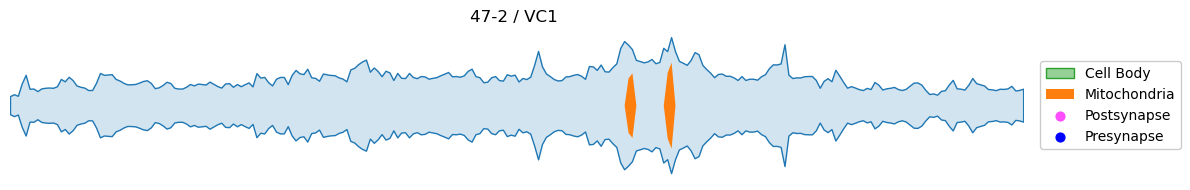

In [31]:
visualize_branch('47-2')

## Obtaining radii to find varicosities/boutons within neurons

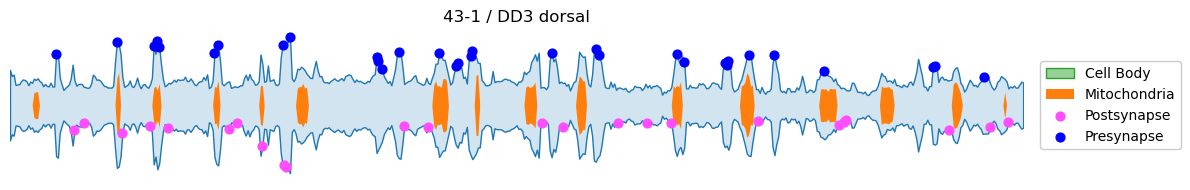

(0.0, 0.373304580636634)

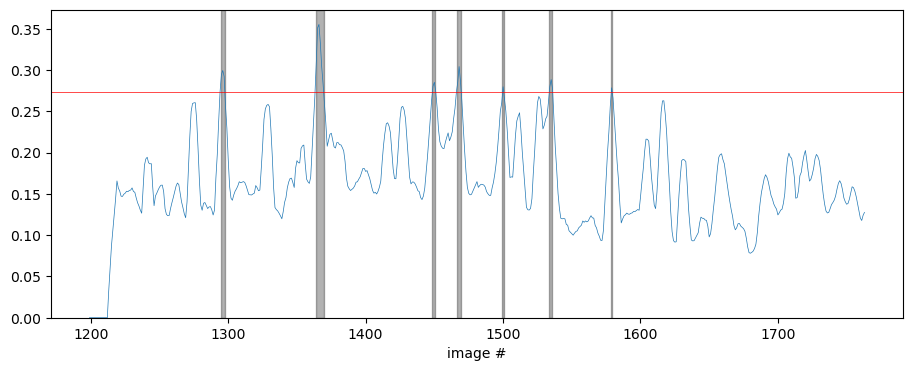

In [40]:
window = 7
neu    = '43-1' 
### If the neuron set contains no cell body ###
df     = data['43-1']['total area'].copy()
radius = np.sqrt(df.copy()/np.pi)

rad_rl = radius.rolling(window=window).mean()
r0 = rad_rl.mean()
dr = rad_rl.std()
B  = rad_rl>r0+2*dr
boutons = get_object_ranges(B)

dist_bout = []
bout_len  = []
for i in range(len(boutons[:-1])):
    dist_bout.append(interslice_distance*( min(boutons[i+1]) - max(boutons[i])))
for i in range(len(boutons[:])):
    bout_len.append(interslice_distance*abs(( min(boutons[i]) - max(boutons[i]))))
#rad_rl = radius.rolling(5).mean()

visualize_branch('43-1')
#%matplotlib notebook
ax = rad_rl.plot(lw=0.5, figsize=(11,4))
ax.axhline(r0+1.9*dr, color='r', lw=0.5)
for bouton in boutons:
    ax.axvspan(bouton[0]-0.5, bouton[1]-0.5, color='k', alpha=0.3)
ax.set_ylim(0,None)## Obtaining radii to find varicosities/boutons within neurons